# Analisis de Residuales

En este notebook introduciremos el *analisis de residuales* visto hasta el momento para verificar algunos supuestos del modelo. Especificamente, en este análisis se intenta poner en tela de juicio los supuestos de 

1. Normalidad
2. Homocedasticidad

Además, con este análisis podemos identificar, bajo el contexto de la muestra, observaciones influyentes, típicamente *outliers*

## Diseño 

Trabajaremos con `ggplot2` para hacer todo tipo de gráficos. A continuacion cargamos las librerías necesarias (quizás no todas son necesarias)

In [ ]:
#install.packages('fitdistrplus')
#library(fitdistrplus)
library(MASS) # Libreria Auxiliar
library(ggplot2) # Librería para Graficar
install.packages('latex2exp')
library(latex2exp) # Expresiones TeX
library(dplyr)  # Manipulacion de DataFrames
install.packages('qpcR')
library(qpcR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘htmlwidgets’, ‘DEoptimR’, ‘minpack.lm’, ‘rgl’, ‘robustbase’


Loading required package: minpack.lm

Loading required package: rgl

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”
Warning message:
“'rgl.init' failed, running with 'rgl.useNULL = TRUE'.”
Loading required package: robustbase

Loading required package: Matrix



In [ ]:
theme_set(theme_gray(base_line_size=0.7,base_family = "Comic Sans MS",base_size = 14))
theme_update(plot.title = element_text(hjust = 0.5))

## Analisis Exploratorio

Comenzamos cargando la base de datos que trabajaremos en este ejemplo. 

**Recordamos**
La base de datos `real_state_data.csv` consta de 20 observaciones sobre informacion de ciertas casas en Milwaukee, Wisconsin. 

Se propone el modelo 
$$
Y_j=\beta_0+\beta_{1}z_{j1}+\beta_{2}z_{j2}+\epsilon_j,
$$
donde 


> $z_{1}$ es el área de la vivienda en cientos de pies cuadrados. 
> $z_2$ es el valor tasado de la vivienda en miles de dolares
> $Y$ es el precio de venta en miles de dolares.

In [ ]:
real_state=read.csv('real_state_data.csv')
colnames(real_state)=c('Size','Assessed','Price')
head(real_state)

,Size,Assessed,Price
,<dbl>,<dbl>,<dbl>
1,15.31,57.3,74.8
2,15.20,63.8,74.0
3,16.25,65.4,72.9
4,14.33,57.0,70.0
5,14.57,63.8,74.9
6,17.33,63.2,76.0


Ahora, hacemos el `scatter plot` para evaluar multicolinealidad

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


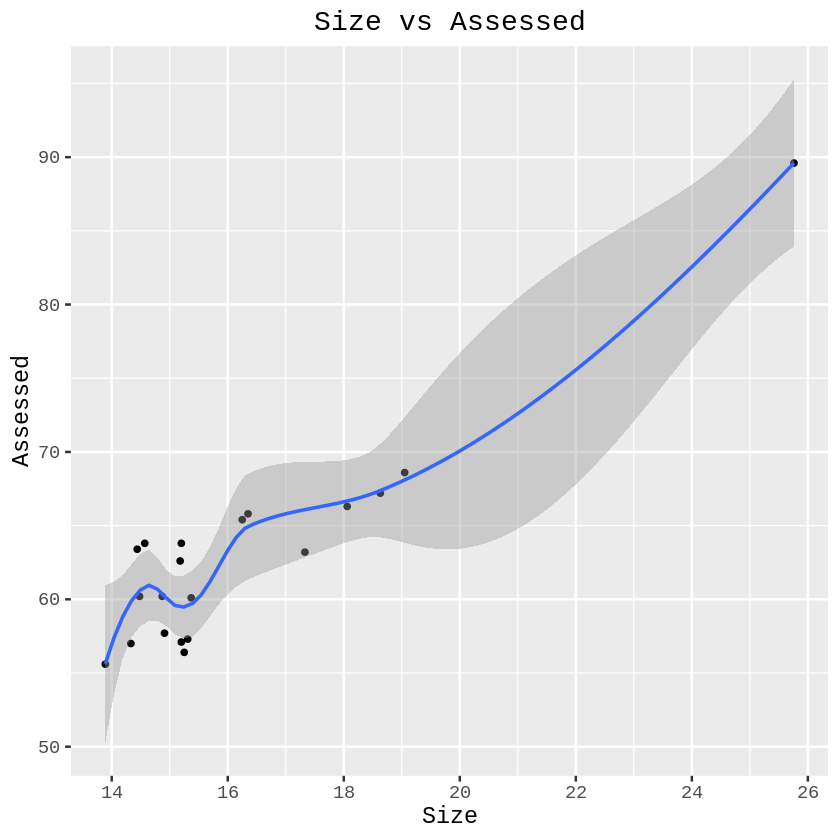

In [ ]:
scatter_expl<-ggplot(data=real_state,aes(x=Size,y=Assessed))+
  geom_point()+
  stat_smooth()+
  ggtitle('Size vs Assessed')
scatter_expl

Loading required package: tidyr


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


`geom_smooth()` using formula = 'y ~ x'


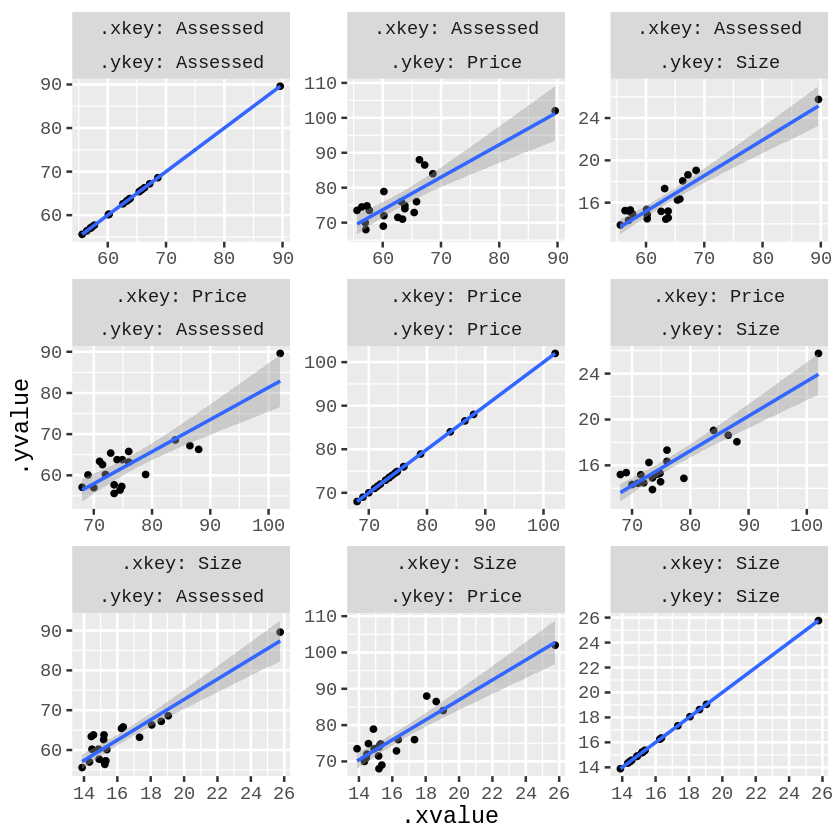

In [ ]:
require(ggplot2) 
require(dplyr)
require(tidyr)

gatherpairs <- function(data, ..., 
                        xkey = '.xkey', xvalue = '.xvalue',
                        ykey = '.ykey', yvalue = '.yvalue',
                        na.rm = FALSE, convert = FALSE, factor_key = FALSE) {
  vars <- quos(...)
  xkey <- enquo(xkey)
  xvalue <- enquo(xvalue)
  ykey <- enquo(ykey)
  yvalue <- enquo(yvalue)

  data %>% {
    cbind(gather(., key = !!xkey, value = !!xvalue, !!!vars,
                 na.rm = na.rm, convert = convert, factor_key = factor_key),
          select(., !!!vars)) 
  } %>% gather(., key = !!ykey, value = !!yvalue, !!!vars,
               na.rm = na.rm, convert = convert, factor_key = factor_key)
}

real_state %>% 
  gatherpairs(Price, Size, Assessed) %>% {
  ggplot(., aes(x = .xvalue, y = .yvalue)) +
      geom_point() + 
      geom_smooth(method = 'lm') +
      facet_wrap(.xkey ~ .ykey, ncol = length(unique(.$.ykey)), scales = 'free', labeller = label_both) +
      scale_color_brewer(type = 'qual')
}

El propósito de esta gráfica es analizar visualmente la relación existente entre las variables independientes, podemos identificar candidatos a observaciones influyentes.

## Análisis de Regresión

A continuacion ajustamos el modelo de regresión deseado

In [ ]:
model_1 <- lm(Price ~ Size + Assessed, data=real_state)

In [ ]:
summary(model_1)


Call:
lm(formula = Price ~ Size + Assessed, data = real_state)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5894 -1.5411 -0.0718  1.3507  6.4605 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) 30.96657    7.88221   3.929  0.00108 **
Size         2.63440    0.78560   3.353  0.00377 **
Assessed     0.04518    0.28518   0.158  0.87598   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.473 on 17 degrees of freedom
Multiple R-squared:  0.8344,	Adjusted R-squared:  0.8149 
F-statistic: 42.83 on 2 and 17 DF,  p-value: 2.302e-07


In [ ]:
help(PRESS)

In [ ]:
model_1_PRESS<-PRESS(model_1)
print(c('Estadistico PRESS: ', model_1_PRESS[[1]]))
print(c('P^2: ', model_1_PRESS[[3]]))

.........10.........20
[1] "Estadistico PRESS: " "264.379036080802"   
[1] "P^2: "             "0.786424231881537"


Observamos de estos resultados que la variabilidad explicada por el modelo es 
$$ R^2= 0.8344, $$
mientras que 
$$ P^2= 0.7864,  $$
con
$$ PRESS=264.38$$

A este punto ya hemos usado los residuales `PRESS` para calcular la variabilidad predicha por el modelo (en el rango de valores observado) y 
el estadístico `PRESS`, con esto, y los *residuales studentizados* completaremos el análisis de residuales. 

El `scatter plot` anterior nos da indicio de que hay al menos una observación extrema la puede identificar que los datos realmente provienen realmente de una distribución con colas más pesadas (la normal tiene colas ligeras). 

A continuación visualizaremos el supuesto de normalidad de los residuos (normalizados)



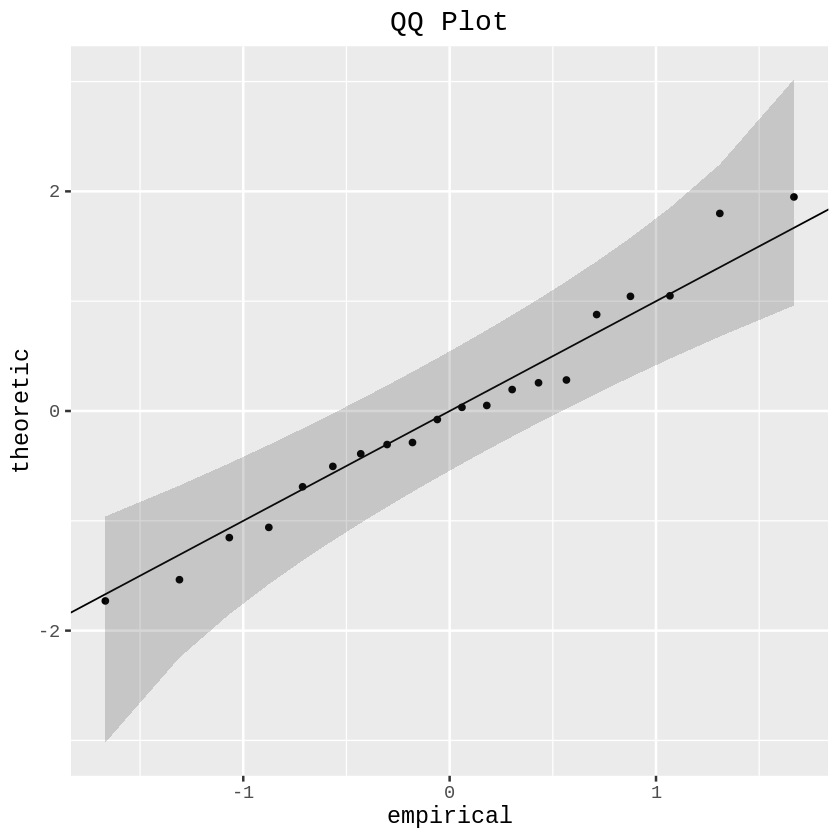

In [ ]:
# QQ Plot de los residuos
SIZE=nrow(real_state)

# Nivel
nivelNew <- 0.05

#Bandas de Confianza
BandSup<-function(k){
  q<-qbeta(nivelNew/2,k,SIZE+1-k)
  return(q)
}
BandInf<-function(k){
  q<-qbeta(1-nivelNew/2,k,SIZE+1-k)
  return(q)
}

# Data frame para graficar
empirical <- seq(1,SIZE)/(SIZE+1)
probData<-pnorm(stdres(model_1),0,1)
theoretic<-sort(probData,decreasing = FALSE)
Index<-c(1:SIZE); supBand=BandSup(Index); infBand=BandInf(Index)

df_plot_PP <- data.frame(supBand,infBand,theoretic,empirical)
df_plot_QQ=data.frame(lapply(df_plot_PP,function(a) qnorm(a,0,1)))

QQ_Plot <-ggplot(df_plot_QQ,aes(x=empirical,y=theoretic))+
geom_point()+geom_abline(slope = 1,intercept = 0)+
geom_ribbon(aes(ymin = infBand, ymax = supBand), alpha = 0.2)+
ggtitle('QQ Plot')

QQ_Plot

Al menos gráficamente, no hay evidencia de no normalidad de los residuos. Para hacer la gráfica anterior usamos los *residuos studentizados*, por lo tanto, hemos considerando quitado en el análisis anterior el *efecto palanca* de los datos, esto fue siguiente la sugerencia de *Christensen 2011: Plane Answers to Complex Questions* sobre que los métodos para detectar no normalidad son susceptibles a la heterocedasticidad. 

Si usaramos los residuos normales tendríamos lo siguiente

In [ ]:
hat_sigma=c(crossprod(model_1$residuals))/model_1$df.residual
hat_sigma

[1] 12.05853

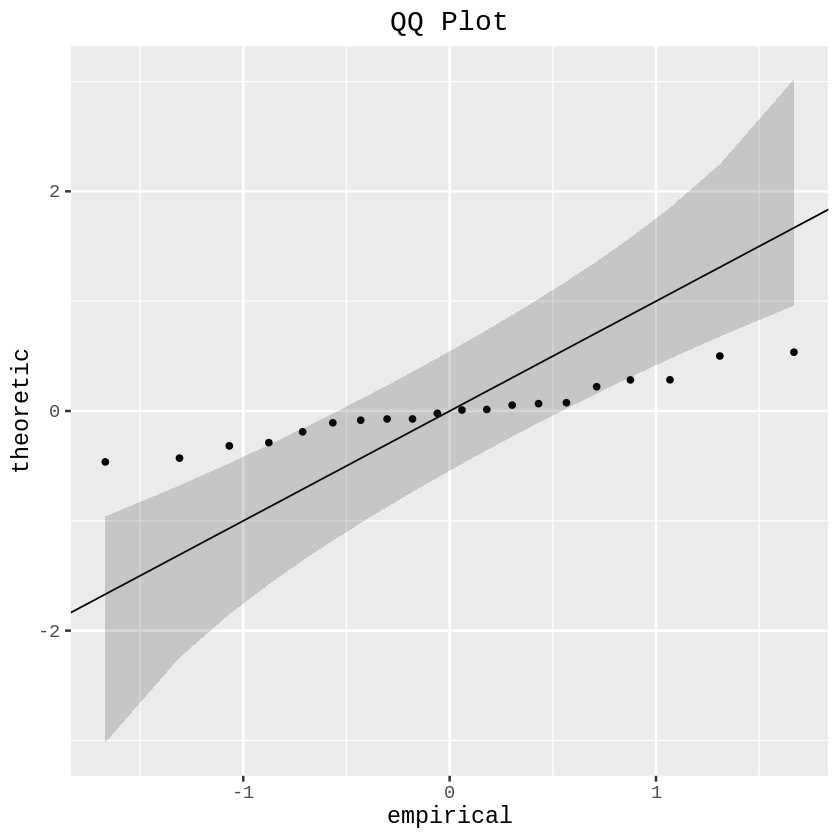

In [ ]:
# Data frame para graficar
empirical <- seq(1,SIZE)/(SIZE+1)
probData<-pnorm(model_1$residuals/hat_sigma,0,1)
theoretic<-sort(probData,decreasing = FALSE)
Index<-c(1:SIZE); supBand=BandSup(Index); infBand=BandInf(Index)

df_plot_PP <- data.frame(supBand,infBand,theoretic,empirical)
df_plot_QQ=data.frame(lapply(df_plot_PP,function(a) qnorm(a,0,1)))

QQ_Plot <-ggplot(df_plot_QQ,aes(x=empirical,y=theoretic))+
geom_point()+geom_abline(slope = 1,intercept = 0)+
geom_ribbon(aes(ymin = infBand, ymax = supBand), alpha = 0.2)+
ggtitle('QQ Plot')

QQ_Plot

La diferencia entre estos `qq plot` muestra el efecto de la heterocedasticidad en la evaluación gráfica de no normalidad (apalancamiento), lo que da razón al libro citado.

## Residuales y Residuales Studentizados


### Normalidad
Ahora realizamos la `qqplot` pero considerando los *residuales estudentizados externamente* o *R-residuales*

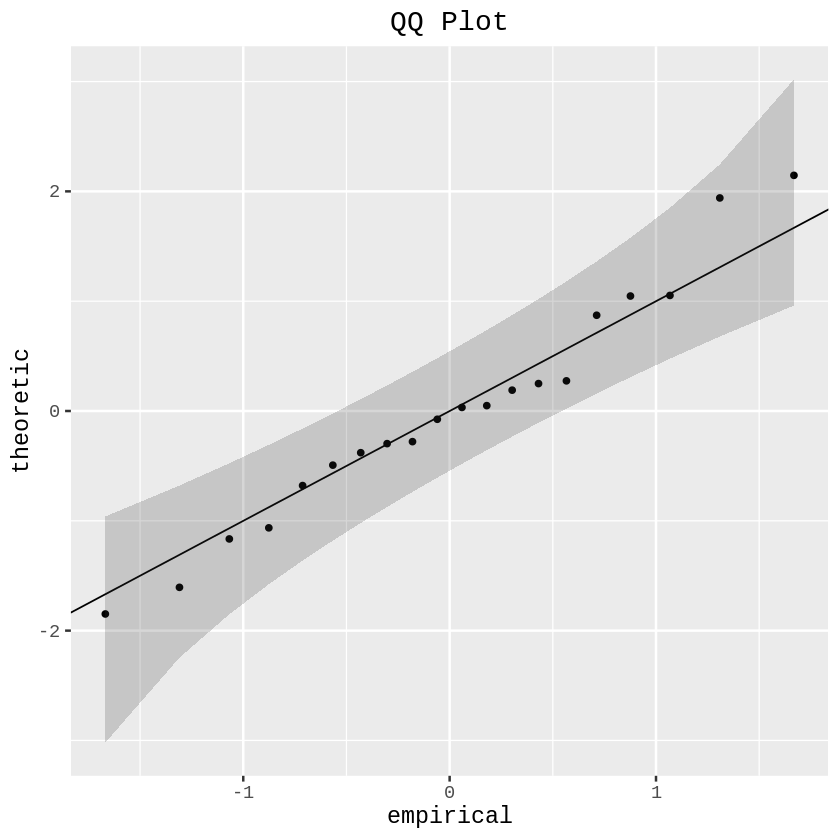

In [ ]:
# Data frame para graficar
empirical <- seq(1,SIZE)/(SIZE+1)
probData<-pnorm(studres(model_1),0,1)
theoretic<-sort(probData,decreasing = FALSE)
Index<-c(1:SIZE); supBand=BandSup(Index); infBand=BandInf(Index)

df_plot_PP <- data.frame(supBand,infBand,theoretic,empirical)
df_plot_QQ=data.frame(lapply(df_plot_PP,function(a) qnorm(a,0,1)))

QQ_Plot <-ggplot(df_plot_QQ,aes(x=empirical,y=theoretic))+
geom_point()+geom_abline(slope = 1,intercept = 0)+
geom_ribbon(aes(ymin = infBand, ymax = supBand), alpha = 0.2)+
ggtitle('QQ Plot')

QQ_Plot

### Residuales vs Valores ajustados

Ahora hacemos la gráfica de los residuales studentizados (eje Y) con los valores predichos (eje X)

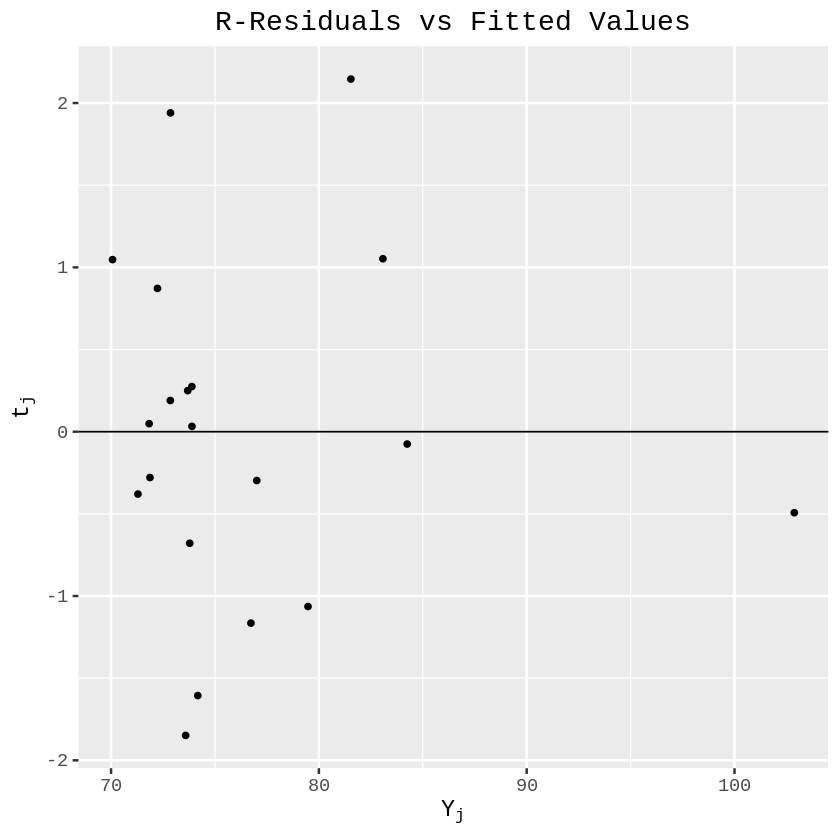

In [ ]:
fitted=model_1$fitted.values
stud_res=studres(model_1)
df_res_fitted=data.frame(fitted,stud_res)

res_vs_fit<-ggplot(data=df_res_fitted,aes(x=fitted,y=stud_res))+
  geom_point()+
  geom_abline(slope=0,intercept = 0)+
  xlab(TeX(r"($Y_j$)"))+
  ylab(TeX(r"($t_j$)"))+
  ggtitle("R-Residuals vs Fitted Values")

res_vs_fit

### Residuales contra regresores

Repetimos el ejercicio anterior considerando las variables independientes `Size` y `Assessed`.



In [ ]:
attach(real_state)

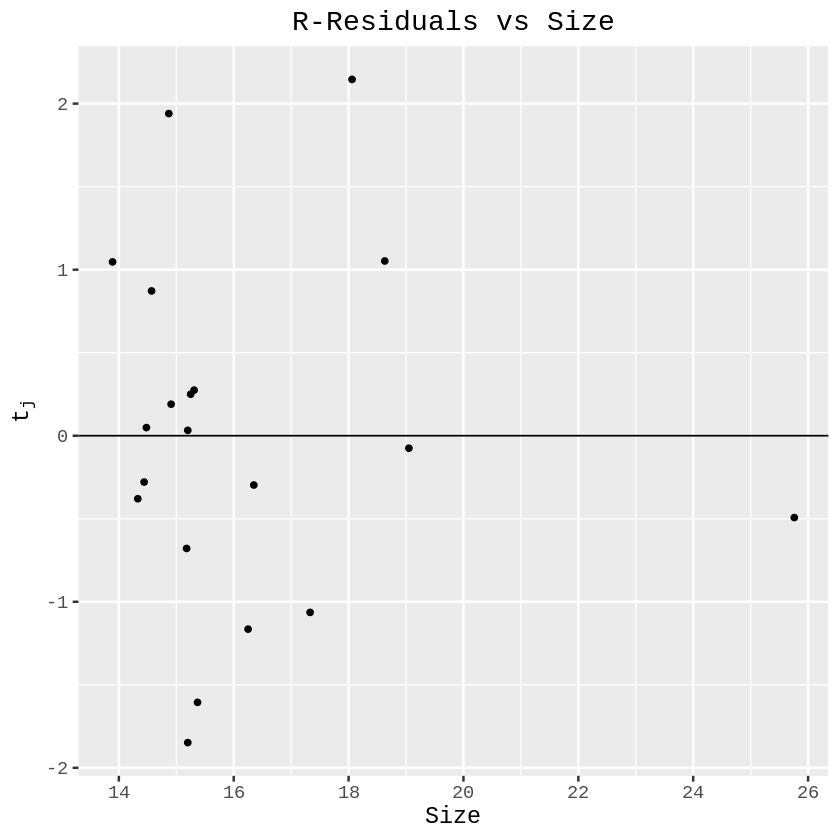

In [ ]:
stud_res=studres(model_1)
df_res_Size=data.frame(Size,stud_res)

res_vs_Size<-ggplot(data=df_res_Size,aes(x=Size,y=stud_res))+
  geom_point()+
  geom_abline(slope=0,intercept = 0)+
  ylab(TeX(r"($t_j$)"))+
  ggtitle("R-Residuals vs Size")

res_vs_Size

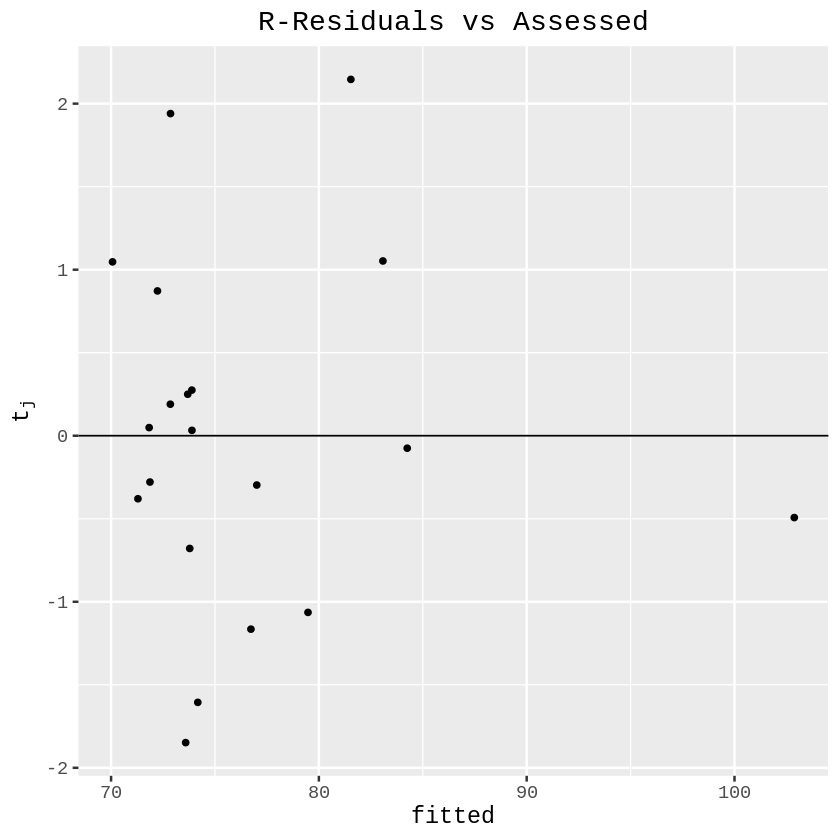

In [ ]:
stud_res=studres(model_1)
df_res_Assessed=data.frame(Assessed,stud_res)

res_vs_Assessed<-ggplot(data=df_res_fitted,aes(x=fitted,y=stud_res))+
  geom_point()+
  geom_abline(slope=0,intercept = 0)+
  ylab(TeX(r"($t_j$)"))+
  ggtitle("R-Residuals vs Assessed")

res_vs_Assessed